<a href="https://colab.research.google.com/github/sourcecode369/Kaggle-Kernels/blob/master/Severstal_Steel_Defect_Detection/Severstal_Steel_Defect_Detection_2_Step_Pipeline_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"rhtsingh","key":"05e5c425aae6dfba32a031192446751a"}'}

In [0]:
!mkdir ~/.kaggle
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c severstal-steel-defect-detection

 72% 5.00M/6.91M [00:00<00:00, 19.9MB/s]
100% 6.91M/6.91M [00:00<00:00, 22.8MB/s]
  0% 0.00/141k [00:00<?, ?B/s]
100% 141k/141k [00:00<00:00, 37.6MB/s]
100% 1.16G/1.16G [00:16<00:00, 87.6MB/s]
100% 1.16G/1.16G [00:16<00:00, 75.9MB/s]
 82% 106M/129M [00:02<00:00, 39.7MB/s] 
100% 129M/129M [00:02<00:00, 63.7MB/s]


In [9]:
import zipfile
import os
import shutil
zip_files = []
for file_name in os.listdir():
  print(f"{file_name}   {zipfile.is_zipfile(file_name)}") 
  if zipfile.is_zipfile(file_name):
    zip_files.append(file_name)

.config   False
train_images   False
test_images.zip   True
train_images.zip   True
sample_submission.csv   False
train.csv.zip   True
sample_data   False


In [0]:
for file in zip_files:
  if ".csv" in file:
    with zipfile.ZipFile(file, 'r') as zip_ref:
      zip_ref.extractall()
  else:
    with zipfile.ZipFile(file, 'r') as zip_ref:
      dir = file.replace(".zip","")
      zip_ref.extractall(dir)

In [0]:
!rm -rf test_images.zip
!rm -rf train_images.zip
!rm -rf train.csv.zip

In [21]:
import os
os.environ["PYTHONHASHSEED"] = str(101)
import gc
gc.enable()
gc.collect()

import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
%matplotlib inline

import keras
from keras import backend as K
from keras.models import Model 
from keras.layers import Input 
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D 
from keras.layers.merge import concatenate 
from keras.losses import binary_crossentropy
from keras.callbacks import Callback, ModelCheckpoint 
from keras.optimizers import Adam, Nadam
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm 
from sklearn.model_selection import train_test_split 

Using TensorFlow backend.


In [22]:
train_df = pd.read_csv('train.csv')
print(train_df.shape)
train_df.head()

(50272, 2)


,ImageId_ClassId,EncodedPixels
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...
1,0002cc93b.jpg_2,NaN
2,0002cc93b.jpg_3,NaN
3,0002cc93b.jpg_4,NaN
4,00031f466.jpg_1,NaN


In [23]:
submission_df = pd.read_csv('sample_submission.csv')
print(submission_df.shape)
submission_df.head()

(7204, 2)


,ImageId_ClassId,EncodedPixels
0,004f40c73.jpg_1,1 1
1,004f40c73.jpg_2,1 1
2,004f40c73.jpg_3,1 1
3,004f40c73.jpg_4,1 1
4,006f39c41.jpg_1,1 1


In [0]:
unique_test_images = submission_df.ImageId_ClassId.apply(lambda x: x.split("_")[0]).unique()

In [25]:
print(f"unique test images: {unique_test_images}")
print(f"unique test images shape: {unique_test_images.shape}")

unique test images: ['004f40c73.jpg' '006f39c41.jpg' '00b7fb703.jpg' ... 'ffbf79783.jpg'
 'ffc9a6187.jpg' 'ffdb60677.jpg']
unique test images shape: (1801,)


In [26]:
train_df["isNan"] = pd.isna(train_df.EncodedPixels).astype(np.int)

train_df["ImageId"] = train_df.ImageId_ClassId.apply(
    lambda x: x.split('_')[0]
)
train_df.head()

,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,1,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,1,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,1,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg


In [27]:
train_nan_df = train_df.groupby("ImageId",axis=0).agg("sum") 
train_nan_df.reset_index(inplace=True)
train_nan_df.rename(columns={"isNan":"missingCount"}, inplace=True)
train_nan_df["allMissing"] = (train_nan_df["missingCount"]==4).astype(np.int)
train_nan_df.head()

,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [28]:
test_nan_df = pd.DataFrame(unique_test_images, columns=['ImageId'])
print(test_nan_df.shape)
test_nan_df.head()

(1801, 1)


,ImageId
0,004f40c73.jpg
1,006f39c41.jpg
2,00b7fb703.jpg
3,00bbcd9af.jpg
4,0108ce457.jpg


In [29]:
print(train_nan_df.shape)
train_nan_df.head()

(12568, 3)


,ImageId,missingCount,allMissing
0,0002cc93b.jpg,3,0
1,00031f466.jpg,4,1
2,000418bfc.jpg,4,1
3,000789191.jpg,4,1
4,0007a71bf.jpg,3,0


In [30]:
print(train_df.shape)
train_df.head()

(50272, 4)


,ImageId_ClassId,EncodedPixels,isNan,ImageId
0,0002cc93b.jpg_1,29102 12 29346 24 29602 24 29858 24 30114 24 3...,0,0002cc93b.jpg
1,0002cc93b.jpg_2,NaN,1,0002cc93b.jpg
2,0002cc93b.jpg_3,NaN,1,0002cc93b.jpg
3,0002cc93b.jpg_4,NaN,1,0002cc93b.jpg
4,00031f466.jpg_1,NaN,1,00031f466.jpg


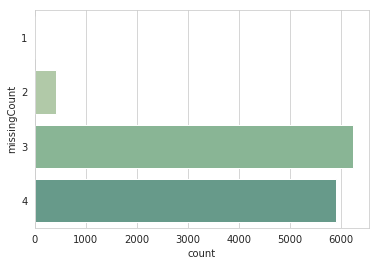

In [31]:
import seaborn as sns
sns.set_style("whitegrid")
sns.countplot(y="missingCount",data=train_nan_df, palette=sns.cubehelix_palette(8, start=.5, rot=-.75))

In [0]:
def load_image(code, base, resize=True):
  path = f'{base}/{code}'
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256,256))
  return img

def validate_path(path):
  if not os.path.exists(path):
    os.makedirs(path)

In [33]:
import os
os.getcwd()

'/content'

In [35]:
train_path = "../train"
validate_path(train_path)

for code in tqdm(train_nan_df.ImageId):
  img = load_image(
      code, "/content/train_images", 
  )
  path = code.replace(".jpg","")
  cv2.imwrite(f"{train_path}/{path}.png",img)

100%|██████████| 12568/12568 [01:58<00:00, 105.33it/s]


In [0]:
train_nan_df["ImageId"] = train_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [37]:
test_path = '../test'
validate_path(test_path)

def load_test_images(code, base, resize=True):
  path = f"{base}/{code}"
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  if resize:
    img = cv2.resize(img, (256, 256))
  return img

for code in tqdm(test_nan_df.ImageId):
  img = load_test_images(code, "/content/test_images", resize=True)
  path = code.replace(".jpg", "")
  cv2.imwrite(f"{test_path}/{path}.png",img) 

100%|██████████| 1801/1801 [00:15<00:00, 116.69it/s]


In [0]:
test_nan_df["ImageId"] = test_nan_df.ImageId.apply(lambda x: x.replace(".jpg",".png"))

In [0]:
BATCH_SIZE = 32
def create_datagen():
  return ImageDataGenerator(
      zoom_range=0.1,
      fill_mode="constant",
      cval=0,
      rotation_range=10,
      height_shift_range = 0.1,
      width_shift_range= 0.1,
      horizontal_flip = True,
      vertical_flip = True, 
      rescale = 1/255.,
      validation_split = 0.15
  )

def create_test_gen():
  return ImageDataGenerator(rescale=1/255.).flow_from_dataframe(test_nan_df,
                                                                directory="../test/",
                                                                x_col="ImageId",
                                                                target_size=(256,256),
                                                                class_mode=None,
                                                                batch_size=BATCH_SIZE,
                                                                shuffle=False
                                                                )
def create_flow(datagen, subset):
  return datagen.flow_from_dataframe(
      train_nan_df,
      directory = "../train/",
      x_col="ImageId",
      y_col="allMissing",
      class_mode="other",
      target_size=(256,256),
      BATCH_SIZE=BATCH_SIZE,
      subset=subset
  )      

In [40]:
data_generator = create_datagen()
train_gen = create_flow(data_generator, "training")
val_generator = create_flow(data_generator, "validation")
test_gen = create_test_gen()

Found 10683 validated image filenames.
Found 1885 validated image filenames.
Found 1801 validated image filenames.


In [0]:
from keras.applications import ResNet50
from keras.layers import *
from keras.utils import plot_model
from keras import Sequential

In [0]:
def build_model():
  resnet = ResNet50(
      include_top = False,
      input_shape = (256,256,3),
      weights = "imagenet"
  )
  resnet.trainable = False
  model = Sequential()
  model.add(resnet)
  model.add(GlobalAveragePooling2D())
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(512, activation="relu",kernel_initializer="he_uniform"))
  model.add(BatchNormalization())
  model.add(Dropout(0.5))
  model.add(Dense(1, activation="sigmoid"))

  model.compile(
      loss = "binary_crossentropy",
      optimizer = Nadam(),
      metrics = ["accuracy"]
  )

  model.summary()
  
  plot_model(model)
  
  return model

In [43]:
model = build_model()

/usr/local/lib/python3.6/dist-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 7s 0us/step
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)   

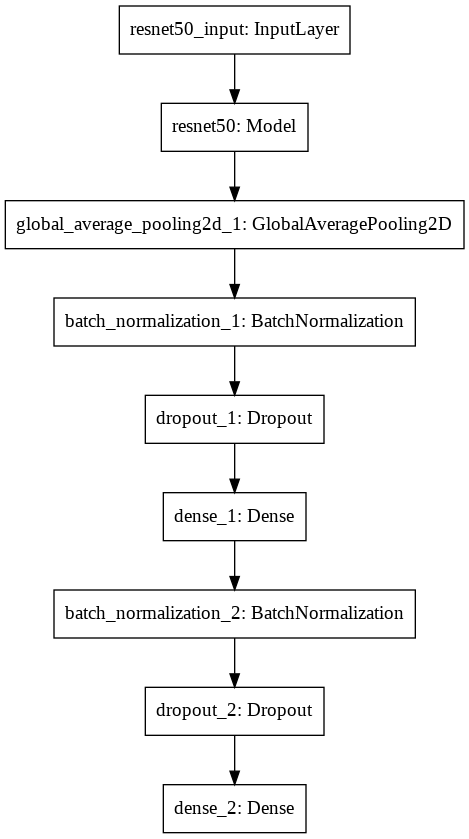

In [44]:
plot_model(model)

In [0]:
from keras.callbacks import *

In [46]:
total_steps = train_nan_df.shape[0] // BATCH_SIZE

checkpoint = ModelCheckpoint(
    "resnet_model.h5",
    monitor = "val_acc",
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
    mode = "auto"
)

reduce_lr = ReduceLROnPlateau(
    monitor = "val_loss",
    factor = 0.3,
    patience = 5,
    verbose = 1,
    min_lr = 1e-6
)

early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 8,
    verbose = 1,
    mode = "auto",
)

history = model.fit_generator(
    train_gen, 
    steps_per_epoch = total_steps*0.85,
    validation_data = val_generator,
    validation_steps = total_steps*0.15,
    epochs = 10,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/10
334/333 [==============================] - 238s 713ms/step - loss: 0.4961 - acc: 0.7863 - val_loss: 1.2243 - val_acc: 0.4748

Epoch 00001: val_acc improved from -inf to 0.47480, saving model to resnet_model.h5
Epoch 2/10
334/333 [==============================] - 224s 672ms/step - loss: 0.3862 - acc: 0.8225 - val_loss: 1.0807 - val_acc: 0.4748

Epoch 00002: val_acc improved from 0.47480 to 0.47480, saving model to resnet_model.h5
Epoch 3/10
334/333 [==============================] - 226s 678ms/step - loss: 0.3659 - acc: 0.8300 - val_loss: 0.9386 - val_acc: 0.4748

Epoch 00003: val_acc did not improve from 0.47480
Epoch 4/10
334/333 [==============================] - 226s 678ms/step - loss: 0.3510 - acc: 0.8423 - val_loss: 0.7257 - val_acc: 0.4748

Epoch 00004: val_acc did not improve from 0.47480
Epoch 5/10
334/333 [==============================] - 226s 677ms/step - loss: 0.3458 - acc: 0.8440 - val_loss: 0.9107 - val_acc: 0.4748

Epoch 00005: val_acc did not improve from 0.

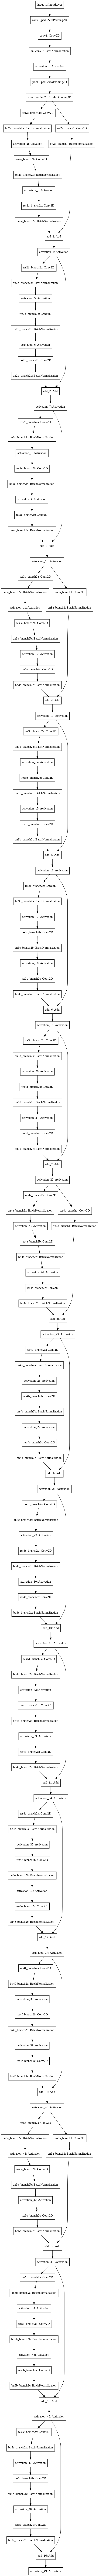

In [59]:
plot_model(model.layers[0])

In [85]:
print("Number of layers in the base model: ", len(model.layers))
print("Number of resnet layers: ", len(model.layers[0].layers))
fine_tune_at = 0
model.layers[0].trainable = True

Number of layers in the base model:  8
Number of resnet layers:  175


In [0]:
for i in range(3, 95):
  model.layers[0].layers[i].trainable=False

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer = Nadam(),
              metrics=['accuracy'])

In [105]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 2048)              8192      
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
batch_normalization_2 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)              

In [106]:
fined_history = model.fit_generator(
    train_gen, 
    steps_per_epoch = total_steps*0.85,
    validation_data = val_generator,
    validation_steps = total_steps*0.15,
    epochs = 40,
    callbacks=[early_stopping, reduce_lr, checkpoint]
)

Epoch 1/40
334/333 [==============================] - 280s 840ms/step - loss: 0.4390 - acc: 0.7981 - val_loss: 0.3788 - val_acc: 0.8897

Epoch 00001: val_acc improved from 0.47480 to 0.88966, saving model to resnet_model.h5
Epoch 2/40
334/333 [==============================] - 267s 801ms/step - loss: 0.2992 - acc: 0.8714 - val_loss: 0.2185 - val_acc: 0.9119

Epoch 00002: val_acc improved from 0.88966 to 0.91194, saving model to resnet_model.h5
Epoch 3/40
334/333 [==============================] - 267s 799ms/step - loss: 0.2593 - acc: 0.8952 - val_loss: 0.2256 - val_acc: 0.9072

Epoch 00003: val_acc did not improve from 0.91194
Epoch 4/40
334/333 [==============================] - 267s 799ms/step - loss: 0.2345 - acc: 0.9036 - val_loss: 0.1705 - val_acc: 0.9358

Epoch 00004: val_acc improved from 0.91194 to 0.93581, saving model to resnet_model.h5
Epoch 5/40
334/333 [==============================] - 267s 800ms/step - loss: 0.2174 - acc: 0.9133 - val_loss: 0.1721 - val_acc: 0.9347

Epoc

KeyboardInterrupt: ignored

In [0]:
def plot_learning(history):
    plt.figure(figsize=(20,12))
    plt.subplot(2,1,1)
    plt.plot(history["epochs"], history["acc"], label="Training Accuracy")
    plt.plot(history["epochs"], history["val_acc"], label="Validation Accuracy")
    plt.grid(True)
    plt.scatter(history["epochs"], history["acc"])
    plt.scatter(history["epochs"], history["val_acc"])
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)

    plt.subplot(2,1,2)
    plt.plot(history["epochs"], history["loss"], label="Training Loss")
    plt.plot(history["epochs"], history["val_loss"], label="Validation Loss")
    plt.grid(True)
    plt.scatter(history["epochs"], history["loss"])
    plt.scatter(history["epochs"], history["val_loss"])
    sns.despine(offset=8,trim=True)
    plt.legend(loc=0)
    plt.xticks(rotation=45,fontsize=15)
    plt.yticks(rotation=45,fontsize=15)

In [108]:
fined_history_df = pd.DataFrame(fined_history.history)
fined_history_df["epochs"] = fined_history.epoch
fined_history_df.tail()

NameError: ignored

In [0]:
plot_learning(fined_history_df)

In [109]:
model.load_weights("resnet_model.h5")
y_test = model.predict_generator(
    test_gen,
    steps = len(test_gen),
    verbose = 1
)

57/57 [==============================] - 21s 368ms/step


In [0]:
test_nan_df["allMissing"] = y_test
#fined_history_df.to_csv("history.csv",index=False)
train_nan_df.to_csv("train_missing_count.csv",index=False)
test_nan_df.to_csv("test_missing_count.csv",index=False)

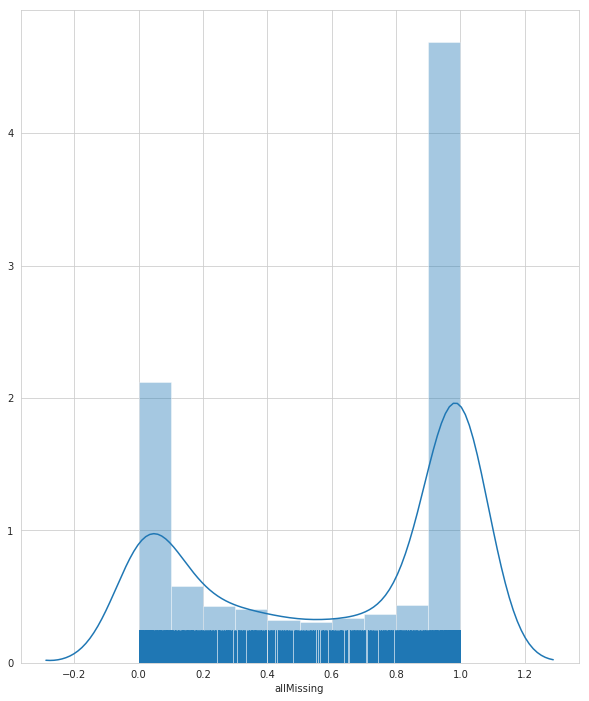

In [111]:
plt.figure(figsize=(10,12))
sns.distplot(test_nan_df["allMissing"],bins=10, rug=True, label="Distribution of Predicted labels")